<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%9A%D0%BE%D0%BD%D1%82%D1%80%D0%B0%D1%81%D1%82%D0%BD%D1%8B%D0%B9_%D0%BB%D0%BE%D1%81%D1%81_%D0%B4%D0%BB%D1%8F_%D1%81%D0%B8%D0%B0%D0%BC%D1%81%D0%BA%D0%B8%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%D1%81_Keras_%D0%B8_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Контрастный лосс для сиамских сетей с Keras и TensorFlow

# Contrast loss for Siamese networks with Keras and TensorFlow

В этом уроке вы узнаете о контрастном лоссе и о том, как их можно использовать для обучения более точных сиамских нейронных сетей. Мы реализуем контрастный лосс с помощью Keras и TensorFlow.


In this tutorial, you will learn about contrast loss and how they can be used to train more accurate Siamese neural networks. We will implement contrasting loss using Keras and TensorFlow.

В прошлых уроках по сиамским нейронным сетям мы узнали, как обучить сиамскую сеть, используя функцию потерь бинарную кросс-энтропию:


In previous tutorials on Siamese neural networks, we learned how to train a Siamese network using the binary cross-entropy loss function:

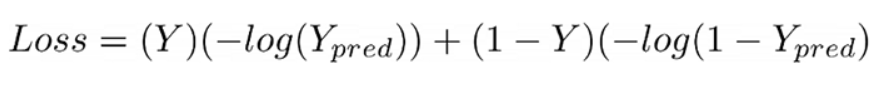

Рисунок - 1: Бинарная кросс-энтропия.

Figure - 1: Binary cross-entropy.

Бинарная кросс-энтропия была здесь правильным выбором, потому что мы делали классификацию двух классов:

Binary cross-entropy was the right choice here because we were doing a classification of two classes:

* Либо два изображения, представленные в сети, принадлежат к одному классу. Either two images on the web belong to the same class
* Либо два изображения принадлежат к разным классам. Either the two images belong to different classes



Однако на самом деле существует функция потерь, гораздо лучше подходящая для сиамских сетей: контрастная потеря.


However, there is actually a loss function much better suited to Siamese networks: contrast loss.

Цель сиамской сети не в том, чтобы классифицировать набор пар изображений, а в том, чтобы различать их. Поэтому, контрастная потеря - это оценка того, насколько хорошо сиамская сеть различает пары изображений. 


The purpose of the Siamese network is not to classify a set of pairs of images, but to distinguish between them. Therefore, contrast loss is an estimate of how well the Siamese network distinguishes between pairs of images.

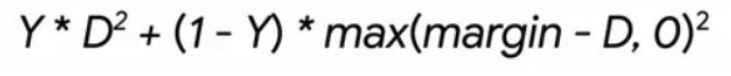

Рисунок 2. - Функция контрастных потерь.

Figure 2. - Contrast loss function.

В этой формуле:

In this formula:

* Значение Y -  наше целевое значение. Оно будет единицей, если пары изображений относятся к одному классу, и будет нулем, если пары изображений относятся к разным классам. The Y value is our target value. It will be one if the pairs of images belong to the same class, and it will be zero if the pairs of images belong to different classes.
* Переменная D - евклидово расстояние между выходами сиамской сети. Variable D is the Euclidean distance between the outputs of the Siamese network.
* Функция max принимает наибольшее значение от нуля и до предельного значения без расстояния. The max function takes the largest value from zero to the limit value without distance.


### Загрузка файлов

### Download the code zip file



In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_15.contrastive_loss_keras.zip
!unzip -qq Lesson_15.contrastive_loss_keras.zip

%cd /content/Lesson_15.contrastive_loss_keras/

--2022-02-21 09:57:13--  http://dataudt.ru/datasets/cv/Lesson_15.contrastive_loss_keras.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 294195 (287K) [application/zip]
Saving to: ‘Lesson_15.contrastive_loss_keras.zip’

Lesson_15.contrasti 100%[===================>] 287.30K  1.63MB/s    in 0.2s    

2022-02-21 09:57:13 (1.63 MB/s) - ‘Lesson_15.contrastive_loss_keras.zip’ saved [294195/294195]

/content/Lesson_15.contrastive_loss_keras


### Импорт библиотек
### Import Packages



In [2]:
# импортируем необходимые библиотеки
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from imutils.paths import list_images
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os

### Класс конфигурации
### Our Config class


In [3]:
class config:
    # указываем входные параметры для нашей нейросети
    # specify the shape of the inputs for our network
    IMG_SHAPE = (28, 28, 1)

    # указываем размер батча и количество эпох
    # specify the batch size and number of epochs
    BATCH_SIZE = 64

    EPOCHS = 100

    # определяем путь к базовой выходной папке
    # define the path to the base output directory
    BASE_OUTPUT = "output"

    # используем базовый путь для вывода модели с сохраненной историей обучения
    # use the base output path to derive the path to the serialized
    # model along with training history plot
    MODEL_PATH = os.path.sep.join([BASE_OUTPUT,
        "contrastive_siamese_model"])
    PLOT_PATH = os.path.sep.join([BASE_OUTPUT,
        "contrastive_plot.png"])

### Создание вспомогательных функций
### Creating our helper utility functions

In [4]:
def make_pairs(images, labels):
    # создаем два пустых списка
	# для хранения пар изображений
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
    # для классов, показывающих является ли пара положительной или отрицательной
	pairLabels = []

    # вычисляем общее количество классов, представленных в датасете
	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
    # создаем список индексов для каждой метки класса,
	# в котором есть индексы для каждого примера с заданной меткой
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

    # проходим циклом через все изображения
	# loop over all images
	for idxA in range(len(images)):
        # выбираем изображение и метку, принадлежащих текущей итерации
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]

        # случайно выбираем изображение, которое принадлежит *тому же* классу
		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]

        # подготавливаем позитивную пару и обновляем изображения и индексы
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])

        # получаем индексы для каждой из меток классов *не* равных текущей метке
		# случайным образом выбираем изображение с меткой, *не* равной текущей метке
		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]

        # подготавливаем негативную пару и обновляем списки
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])

    # возвращаем кортеж, состоящий из пары изображений и их меток
	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

In [5]:
def euclidean_distance(vectors):
    # распределяем векторы в отдельные списки
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors

    # вычисляем сумму квадратов расстояний между векторами
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)

    # возвращаем евклидово расстояние между векторами
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [6]:
def plot_training(H, plotPath):
    # строим графики, отображающие историю обучения
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

### Реализация архитектуры сиамской сети
### Implementing our siamese network architecture

In [7]:
def build_siamese_model(inputShape, embeddingDim=48):
    # указываем входы для признаков сети
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)

    # определяем первый набор слоев: CONV => RELU => POOL => DROPOUT
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)

    # второй набор: CONV => RELU => POOL => DROPOUT layers
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)

    # подготавливаем выходы
	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)

    # создаем модель
	# build the model
	model = Model(inputs, outputs)

    # возвращаем модель вызванной функции
	# return the model to the calling function
	return model

### Реализация контрастного лосса с помощью Keras и TensorFlow
### Implementing contrastive loss with Keras and TensorFlow

In [8]:
def contrastive_loss(y, preds, margin=1):
    # явно указываем истинный тип данныых метки класса к предсказанному
	# (иначе мы рискуем получить два отдельных типа данных, вызывающих ошибку TensorFlow)
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)

    # вычисляем контрастную функцию потерь между истинными метками и
	# предсказанными метками
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    # возвращаем вычисленный контрастный лосс вызывающей функции
	# return the computed contrastive loss to the calling function
	return loss

### Создание кода обучения с контрастным лоссом
### Creating our contrastive loss training script

In [9]:
# загружаем MNIST датасет и нормируем значения пикселей в диапазоне от 0 до 1
# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

# добавляем размерность канала к изображениям
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# подготавливаем позитивную и негативную пары изображений
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

[INFO] loading MNIST dataset...
11501568/11490434 [==============================] - 0s 0us/step
[INFO] preparing positive and negative pairs...


In [10]:
# выбираем конфигурацию для сиамской сети
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=config.IMG_SHAPE)
imgB = Input(shape=config.IMG_SHAPE)
featureExtractor = build_siamese_model(config.IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# собираем получившуюся сеть
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

[INFO] building siamese network...


[INFO] compiling model...
[INFO] training model...
Epoch 1/100
1875/1875 [==============================] - 37s 14ms/step - loss: 0.2009 - val_loss: 0.1702
Epoch 2/100
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1765 - val_loss: 0.1505
Epoch 3/100
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1634 - val_loss: 0.1421
Epoch 4/100
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1550 - val_loss: 0.1345
Epoch 5/100
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1498 - val_loss: 0.1268
Epoch 6/100
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1462 - val_loss: 0.1240
Epoch 7/100
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1437 - val_loss: 0.1213
Epoch 8/100
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1421 - val_loss: 0.1163
Epoch 9/100
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1406 - val_loss: 0.1203
Epoc

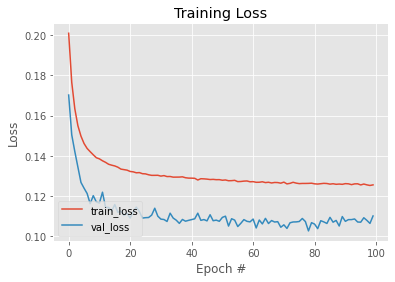

In [11]:
# компилируем модель
# compile the model
print("[INFO] compiling model...")
model.compile(loss=contrastive_loss, optimizer="adam")

# обучаем модель
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=config.BATCH_SIZE,
	epochs=config.EPOCHS)

# сохраняем модель на диск
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(config.MODEL_PATH)

# строим историю обучения
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, config.PLOT_PATH)


### Реализация тестового кода 

### Implementing our contrastive loss test script


In [12]:
# явно укажем аргументы необходимые для работы
# input -  путь к изображениям из тестовой выборки

# explicitly specify the arguments needed to work
# input - the path to the images from the test sample

args = {
    "input": "examples"
}

In [13]:
# указываем путь к изображениям из тестовой выборки, и затем случайным образом сгенерируем
# 10 пар изображений
# grab the test dataset image paths and then randomly generate a
# total of 10 image pairs
print("[INFO] loading test dataset...")
testImagePaths = list(list_images(args["input"]))
np.random.seed(42)
pairs = np.random.choice(testImagePaths, size=(10, 2))

# загрузим модель с диска
# load the model from disk
print("[INFO] loading siamese model...")
model = load_model(config.MODEL_PATH, compile=False)

[INFO] loading test dataset...
[INFO] loading siamese model...


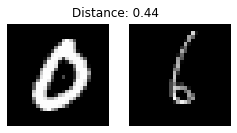

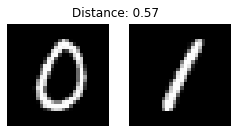

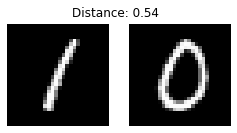

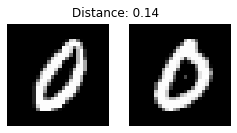

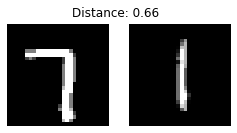

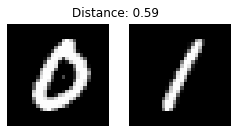

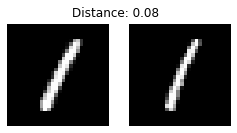

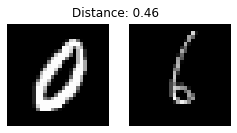

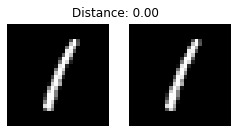

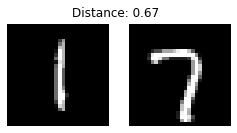

In [14]:
# перебираем все пары изображений
# loop over all image pairs
for (i, (pathA, pathB)) in enumerate(pairs):
    # загружаем оба изображения и конвертируем их в оттенки серого
	# load both the images and convert them to grayscale
	imageA = cv2.imread(pathA, 0)
	imageB = cv2.imread(pathB, 0)

    # создаем копии обоих изображений для визуализации
	# create a copy of both the images for visualization purpose
	origA = imageA.copy()
	origB = imageB.copy()

    # добавляем размерность канала к обоим изображениям
	# add channel a dimension to both the images
	imageA = np.expand_dims(imageA, axis=-1)
	imageB = np.expand_dims(imageB, axis=-1)

    # добавляем размерность батча к обоим изображениям
	# add a batch dimension to both images
	imageA = np.expand_dims(imageA, axis=0)
	imageB = np.expand_dims(imageB, axis=0)

    # нормируем значения пикселей в диапазоне [0, 1]
	# scale the pixel values to the range of [0, 1]
	imageA = imageA / 255.0
	imageB = imageB / 255.0

    # используем нашу сиамскую модель, чтобы делать предсказания для пары изображений,
	# указываем, принадлежат ли изображения к одному классу
	# use our siamese model to make predictions on the image pair,
	# indicating whether or not the images belong to the same class
	preds = model.predict([imageA, imageB])
	proba = preds[0][0]

    # создаем фигуру
	# initialize the figure
	fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
	plt.suptitle("Distance: {:.2f}".format(proba))

    # отображаем первое изображение
	# show first image
	ax = fig.add_subplot(1, 2, 1)
	plt.imshow(origA, cmap=plt.cm.gray)
	plt.axis("off")

    # отображаем второе изображение
	# show the second image
	ax = fig.add_subplot(1, 2, 2)
	plt.imshow(origB, cmap=plt.cm.gray)
	plt.axis("off")

    # визулизируем все
	# show the plot
	plt.show()